# Data Observability Toolkit Library (*DOTKit Lib*)

## Presentación de los detalles del trabajo

Detalles del trabajo:
* Todo el código parte de la idea de Andy Petrella: [Fundamentals-of-Data-Observability/oreilly-fodo-source-code](https://github.com/Fundamentals-of-Data-Observability/oreilly-fodo-source-code/blob/main/ch3/mp_3-20.py).
* El Diagrama de Clases (UML) se encuentra en el siguiente enlace: [Diagrama de Clases *DOTKit Lib*](https://drive.google.com/file/d/1PUFU9CiwZVbsQGMjYE8sy5wnPkQDsrXV/view?usp=sharing).

Pasos para desarrollar el proyecto:
1. La idea inicial es formalizar un conjunto de clases extensibles que contengan el núcleo de las competencias en materia de observabilidad de datos respecto a las entidades del modelo *core* presentado posteriormente.
2. El siguiente paso consistiría en aplicar el patrón de diseño de software *Decorador* (Decorator Software Design Pattern) a cada entidad, permitiendo al usuario embeber cada clase con la funcionalidad y la información necesarias.
3. El tercer paso sería desarrollar uno o más conectores con diferentes bases de datos tanto relacionales como NoSQL (tengamos en cuenta que existen claras relaciones entre las distintas entidades, por lo que es necesario cuidar la redundancia y otros aspectos) para registrar los resultados de los procesos de observabilidad de datos.
4. Por último, solo faltaría construir herramientas de aplicación de estas completencias a las técnicas básicas de tratamiento de datos.

## Imports

In [1]:
import pandas as pd
import hashlib
import json
import re
import os
from abc import ABC, abstractmethod

In [2]:
def _default(self, obj):
    return getattr(obj.__class__, "to_json", _default.default)(obj)

_default.default = json.JSONEncoder().default
json.JSONEncoder.default = _default

## Data Observability Core Model

<div>
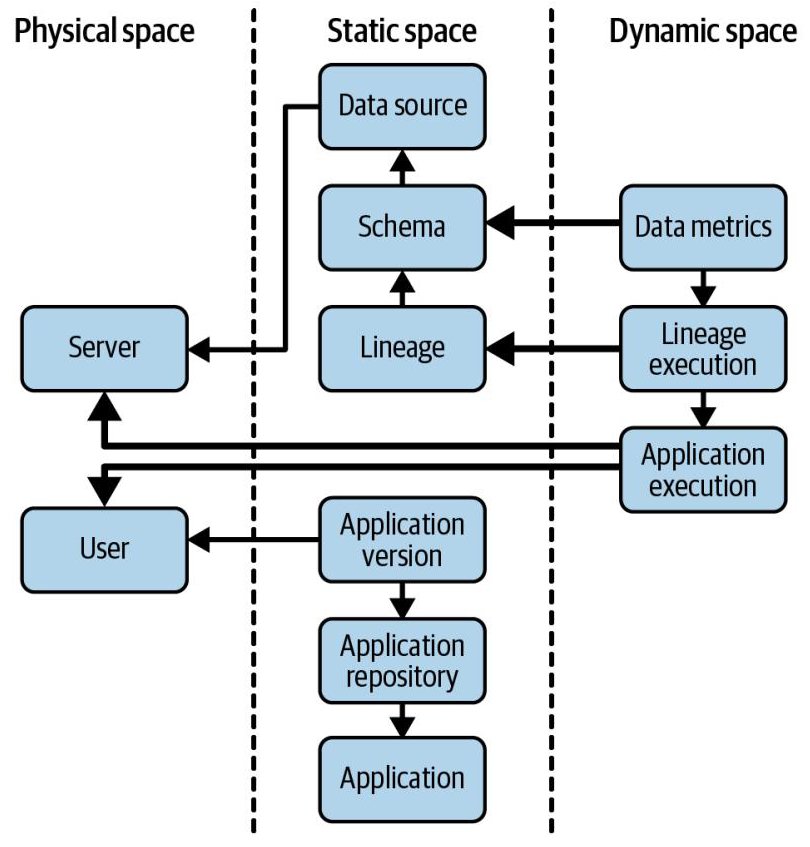
</div>

### Abstract class

In [3]:
class DOEntity(ABC):
    id: str

    def __init__(self) -> None:
        self.id = self.get_id()
    
    def get_id(self) -> str:
        return hashlib.md5(self.primary_key_gen().encode("utf-8")).hexdigest()
    
    def dump(self, file) -> None:
        json.dump(self, file)
        file.write('\r\n')
        
    @abstractmethod
    def to_json(self) -> dict:
        raise NotImplementedError()
        
    @abstractmethod
    def primary_key_gen(self) -> str:
        raise NotImplementedError()

### Physical Space

##### User

In [4]:
class User(DOEntity):
    name: str

    def __init__(self, name: str) -> None:
        self.name = name
        super().__init__()

    def to_json(self) -> dict:
        return {"do_category": "User", "id": self.id, "name": self.name}
        
    def primary_key_gen(self) -> str:
        return self.name

Unitary tests

In [5]:
# init
user1 = User("igmarco")
user2 = User("paascor")

# to_json
print(user1.to_json())
print(user2.to_json())
print()

# dump
file = open("DOFile.txt", "w")
user1.dump(file)
user2.dump(file)
file.close()

file = open('DOFile.txt', 'r')
file_contents = file.read()
print (file_contents)
file.close()

{'do_category': 'User', 'id': '6591935a79dc4b03f8b58c5e79d01273', 'name': 'igmarco'}
{'do_category': 'User', 'id': 'a9e880e293dff74805f8f618f7098147', 'name': 'paascor'}

{"do_category": "User", "id": "6591935a79dc4b03f8b58c5e79d01273", "name": "igmarco"}

{"do_category": "User", "id": "a9e880e293dff74805f8f618f7098147", "name": "paascor"}




##### Server

In [38]:
class Host(DOEntity):
    ip: str
    port: int
    purpose: str
    
    # Atributo estático que contiene los valores permitidos para "purpose"
    allowed_purposes = set(["Application", "Data"])

    def __init__(self, ip: str, port: int, purpose: str) -> None:
            
        # COMPROBACIONES
        # Verifica si el formato de la dirección IP es válido
        ip_pattern = re.compile(r'^\d{1,3}(\.\d{1,3}){3}$')
        if not ip_pattern.match(ip):
            raise ValueError('El formato de la dirección IP no es válido')
            
        # Verifica si el puerto especificado es válido
        if port < 0 or 65535 < port:
            raise ValueError('No se ha especificado un puerto válido')
            
        # Verifica si el propósito indicado es válido
        if purpose not in Host.allowed_purposes:
            raise ValueError(f'El propósito debe ser uno de los siguientes: {", ".join(Host.allowed_purposes)}')

        # ASIGNACIONES
        self.ip = ip
        self.port = port
        self.purpose = purpose
        super().__init__()

    def to_json(self) -> dict:
        return {"do_category": "Host", "id": self.id, "ip": self.ip, "port": self.port, "purpose": self.purpose}
        
    def primary_key_gen(self) -> str:
        return str(self.port) + ":" + self.ip

    @staticmethod
    def add_allowed_purpose(new_purpose) -> None:
        Host.allowed_purposes.add(new_purpose)

    @staticmethod
    def remove_allowed_purpose(old_purpose) -> None:
        Host.allowed_purposes.remove(old_purpose)

    @staticmethod
    def replace_allowed_purpose(old_purpose, new_purpose) -> None:
        Host.remove_allowed_purpose(old_purpose)
        Host.add_allowed_purpose(new_purpose)

    @staticmethod
    def get_allowed_purpose(old_purpose, new_purpose) -> list:
        return Host.allowed_purposes

Unitary tests

In [39]:
# Unitary tests
# init
host1 = Host("192.168.1.1", 8888, "Application")
try:
    host2 = Host("192.168.1.1", 11111111, "Application")
except Exception as e:
    print(e)
try:
    host3 = Host("192.168.1.1", 8888, "Otro tipo")
except Exception as e:
    print(e)
print()

# to_json
print(host1.to_json())
print()

# dump
file = open("DOFile.txt", "w")
host1.dump(file)
file.close()

file = open('DOFile.txt', 'r')
file_contents = file.read()
print (file_contents)
file.close()
print()

# add_allowed_purpose
Host.add_allowed_purpose("Nuevo tipo 1")
Host.add_allowed_purpose("Nuevo tipo 2")
host = Host("192.168.1.1", 8888, "Nuevo tipo 1")
print(host.to_json())
print()

# remove_allowed_purpose
Host.remove_allowed_purpose("Nuevo tipo 1")
try:
    host = Host("192.168.1.1", 8888, "Nuevo tipo 1")
except Exception as e:
    print(e)
print()

# replace_allowed_purpose
Host.replace_allowed_purpose("Nuevo tipo 2", "Nuevo tipo 1")
host = Host("192.168.1.1", 8888, "Nuevo tipo 1")
print(host.to_json())

Host.remove_allowed_purpose("Nuevo tipo 1")

No se ha especificado un puerto válido
El propósito debe ser uno de los siguientes: Data, Application

{'do_category': 'Host', 'id': 'b90931d40587bd45d89897df6bede44f', 'ip': '192.168.1.1', 'port': 8888, 'purpose': 'Application'}

{"do_category": "Host", "id": "b90931d40587bd45d89897df6bede44f", "ip": "192.168.1.1", "port": 8888, "purpose": "Application"}



{'do_category': 'Host', 'id': 'b90931d40587bd45d89897df6bede44f', 'ip': '192.168.1.1', 'port': 8888, 'purpose': 'Nuevo tipo 1'}

El propósito debe ser uno de los siguientes: Data, Nuevo tipo 2, Application

{'do_category': 'Host', 'id': 'b90931d40587bd45d89897df6bede44f', 'ip': '192.168.1.1', 'port': 8888, 'purpose': 'Nuevo tipo 1'}


### Static Space

#### Application Field

##### Application

In [40]:
class Application(DOEntity):
    name: str
    owner: str

    def __init__(self, name: str = None, owner: str = None) -> None:
        self.name = name if name is not None else Application.fetch_file_name()
        self.owner = owner
        super().__init__()

    def to_json(self) -> dict:
        return {"id": self.id, "name": self.name, "owner": self.owner}
        
    def primary_key_gen(self) -> str:
        return ((self.owner + ".") if (self.owner is not None) else "") + self.name

    @staticmethod
    def fetch_file_name() -> str:
        # application_name = os.path.basename(os.path.realpath(__file__))
        application_name = os.path.basename(os.path.realpath(globals().get('__file__', '.')))
        return application_name

In [41]:
Application().to_json()

{'id': '174f074bdc1dbbf18dd4dfc809cd52a6',
 'name': 'D2.1.X - Data Observability implementations',
 'owner': None}

##### Application Repository

In [44]:
class ApplicationRepository:
    location: str
    application: Application

    def __init__(self, application: Application = None, location: str = None) -> None:
        self.location = location if location is not None else ApplicationRepository.fetch_git_location()
        self.location = application if application is not None else Application()
        super().__init__()
        self.id = hashlib.md5(",".join([self.location, self.application.id]).encode("utf-8")).hexdigest()

    def to_json(self):
        return {"id": self.id, "location": self.location, "application": self.application.id}
        
    def primary_key_gen(self) -> str:
        return self.application.primary_key_gen() + "." + self.location

    # Add static method to fetch the git repo
    @staticmethod
    def fetch_git_location():
        import git
        code_repo = git.Repo(os.getcwd(), search_parent_directories=True).remote().url
        return code_repo

In [45]:
ApplicationRepository().to_json()

ModuleNotFoundError: No module named 'git'

##### Application Version

In [12]:
class ApplicationVersion:
    version: str
    user: User
    application_repo: ApplicationRepository
    id: str

    def __init__(self, version: str, user: User, application_repo: ApplicationRepository) -> None:
        self.version = version
        self.user = user
        self.application_repo = application_repo
        self.id = hashlib.md5(
            ",".join([self.version, self.user.id, self.application_repo.id]).encode("utf-8")).hexdigest()

    def to_json(self):
        return {"id": self.id, "version": self.version, "user": self.user.id,
                "application_repository": self.application_repo.id}

    @staticmethod
    def fetch_git_version():
        import git
        repo = git.Repo(os.getcwd(), search_parent_directories=True)
        commit = repo.head.commit
        code_version = commit.hexsha
        return code_version

    @staticmethod
    def fetch_git_author():
        import git
        repo = git.Repo(os.getcwd(), search_parent_directories=True)
        commit = repo.head.commit
        code_author = commit.author.name
        return code_author

#### Data Field

##### Data Source

In [13]:
class DataSource:
    location: str
    format: str
    id: str

    def __init__(self, location: str, format: str = None) -> None:
        self.location = location
        self.format = format
        self.id = hashlib.md5(",".join([self.location, self.format]).encode("utf-8")).hexdigest()

    def to_json(self):
        return {"id": self.id, "location": self.location, "format": self.format}

##### Schema

In [14]:
class Schema:
    fields: list[tuple[str, str]]
    data_source: DataSource
    id: str

    def __init__(self, fields: list[tuple[str, str]], data_source: DataSource) -> None:
        self.fields = fields
        self.data_source = data_source
        linearized_fields = ",".join(list(map(lambda x: x[0] + "-" + x[1], sorted(self.fields))))
        self.id = hashlib.md5(",".join([linearized_fields, self.data_source.id]).encode("utf-8")).hexdigest()

    def to_json(self):
        from functools import reduce
        jfields = reduce(lambda x, y: dict(**x, **y), map(lambda f: {f[0]: f[1]}, self.fields))
        return {"id": self.id, "fields": jfields, "data_source": self.data_source.id}

    @staticmethod
    def extract_fields_from_dataframe(df: pd.DataFrame):
        fs = list(zip(df.columns.values.tolist(), map(lambda x: str(x), df.dtypes.values.tolist())))
        return fs

##### Lineage

In [15]:
class OutputDataLineage:
    schema: Schema
    input_schemas: list[tuple[Schema, dict]]
    id: str

    def __init__(self, schema: Schema, input_schemas_mapping: list[tuple[Schema, dict]]) -> None:
        self.schema = schema
        self.input_schemas_mapping = input_schemas_mapping
        self.id = hashlib.md5(",".join([self.schema.id]).encode("utf-8") + self.linearize().encode("utf-8")).hexdigest()

    def to_json(self):
        return {"id": self.id, "schema": self.schema.id, "input_schemas_mapping": self.input_schemas_mapping}

    @staticmethod
    def generate_direct_mapping(output_schema: Schema, input_schemas: list[Schema]):
        input_schemas_mapping = []
        output_schema_field_names = [f[0] for f in output_schema.fields]
        for schema in input_schemas:
            mapping = {}
            for field in schema.fields:
                if field[0] in output_schema_field_names:
                    mapping[field[0]] = [field[0]]
            if len(mapping):
                input_schemas_mapping.append((schema, mapping))
        return input_schemas_mapping

    def linearize(self):
        linearized = ""
        for schema in self.input_schemas_mapping:
            for k in schema[1]:
                linearized += (k + ":")
                linearized += ("-".join(schema[1][k]) + ",")
        linearized = linearized[:-1]
        return linearized

### Dynamic Space

##### Application Execution

In [16]:
class ApplicationExecution:
    application_version: ApplicationVersion
    user: User
    start_time: str
    id: str

    def __init__(self, application_version: ApplicationVersion, user: User) -> None:
        self.application_version = application_version
        self.user = user
        self.start_time = datetime.datetime.now().isoformat()
        self.id = hashlib.md5(",".join([self.application_version.id, self.user.id]).encode("utf-8")).hexdigest()

    def to_json(self):
        return {"id": self.id, "application_version": self.application_version.id, "user": self.user.id,
                "start_time": self.start_time}

##### Lineage Execution

In [17]:
class LineageExecution:
    lineage: OutputDataLineage
    application_execution: ApplicationExecution
    start_time: str
    id: str

    def __init__(self, lineage: OutputDataLineage, application_execution: ApplicationExecution) -> None:
        self.lineage = lineage
        self.application_execution = application_execution
        self.start_time = datetime.datetime.now().isoformat()
        self.id = hashlib.md5(
            ",".join([self.lineage.id, self.application_execution.id, self.start_time]).encode("utf-8")).hexdigest()

    def to_json(self):
        return {"id": self.id, "lineage": self.lineage.id, "application_execution": self.application_execution.id,
                "start_time": self.start_time}

##### Data Metrics

In [18]:
class DataMetrics:
    schema: Schema
    lineage_execution: LineageExecution
    metrics: list[tuple[str, float]]
    id: str

    def __init__(self, metrics: list[tuple[str, float]], schema: Schema) -> None:
        self.metrics = metrics
        self.schema = schema
        self.id = hashlib.md5(",".join([self.schema.id]).encode("utf-8")).hexdigest()

    def to_json(self):
        from functools import reduce
        jfields = reduce(lambda x, y: dict(**x, **y), map(lambda f: {f[0]: f[1]}, self.metrics))
        return {"id": self.id, "metrics": jfields, "schema": self.schema.id}

    @staticmethod
    def extract_metrics_from_dataframe(df: pd.DataFrame):
        d = df.describe(include='all', datetime_is_numeric=True)
        import math
        import numbers
        metrics = {}
        for field in d.columns[1:]:
            msd = dict(filter(lambda x: isinstance(x[1], numbers.Number) and math.isnan(x[1]) is False,
                              map(lambda x: (field + "." + x[0], x[1]), d[field].to_dict().items())))
            metrics.update(msd)
        return list(metrics.items())

## High-Level tools

### DataFrame Embedding

In [ ]:
pd.options.mode.chained_assignment = None

In [19]:
class DataFrameWithDO:
    df: pd.DataFrame
    ds: DataSource
    sc: Schema
    df_i: list[pd.DataFrame]
    ds_i: list[DataSource]
    sc_i: list[Schema]

    def __init__(self, df: pd.DataFrame, ds: DataSource, sc: Schema, df_i: list[pd.DataFrame] = None,
                 ds_i: list[DataSource] = None, sc_i: list[Schema] = None) -> None:
        self.df = df
        self.ds = ds
        self.sc = sc
        self.df_i = df_i
        self.ds_i = ds_i
        self.sc_i = sc_i

    def astype(self, *args, **kwargs):
        df = pd.DataFrame.astype(self.df, *args, **kwargs)
        return DataFrameWithDO(df, self.ds, self.sc, self.df_i, self.ds_i, self.sc_i)

    def to_csv(self, *args, **kwargs):
        r = original_to_csv(self.df, *args, **kwargs)
        file_name = args[0][0:args[0].rfind('.')]
        file_format = args[0][args[0].rfind('.') + 1:]
        ds = DataSource(file_name, file_format)
        print(json.dumps(ds))
        sc = Schema(Schema.extract_fields_from_dataframe(self.df), ds)
        print(json.dumps(sc))
        lineage = OutputDataLineage(sc,
                                    OutputDataLineage.generate_direct_mapping(sc, self.sc_i))
        print(json.dumps(lineage))
        lineage_exe = DataLineageExecution(lineage, app_exe)
        print(json.dumps(lineage_exe))
        for (df_l, sc_l) in zip(self.df_i, self.sc_i):
            ms = DataMetrics(DataMetrics.extract_metrics_from_df(df_l), sc_l, lineage_exe)
            print(json.dumps(ms))
        ms = DataMetrics(DataMetrics.extract_metrics_from_df(self.df), sc, lineage_exe)
        print(json.dumps(ms))
        return r